## CA Housing Data Project

David Douglas

This project takes a look at housing data from the 1990 Census and using visualization and regression models with GeoPlot and PySpark, can calculate what factors most into median housing prices absent of typical data such as acreage, condition, and proximity to cities/schools/parks. The census data consisted of median age of the buildings, number of rooms, number of bedrooms, population, households, median income, median house value and ocean proximity of a given block in CA, there are over 20433 valid data points in this set. What this project ended up showing that median income is the most influential aspect of median house value, followed by ocean proximity and median house age. The other catagories did have small effects on the prices but overall their effect was nearly negligible. The visual data shows how the median income and ocean proximity are often related, but there are also some outliers and thats why ocean proximity alone is not a good indicator.

There are no special instructions to run this notebook

This notebook uses pyspark and findspark to find the files necessary to import spark

The most recent version of pyspark can be installed via pip

pip install pyspark

And findspark can be installed by running

pip install findspark

The project uses geopandas to manage geographical data which can be installed with pip

pip install geopandas

Last of all it uses geoplot to help with the geographic data plotting, this can be installed with pip

pip install geoplot

However due to a lot of dependancies its easier to use

conda install geoplot -c conda-forge

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql as sql 
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
import pandas as pd
import numpy as np
import geopandas
import geoplot
import matplotlib.pyplot as plt
import pyspark.sql.types as types

Here is where the file is loaded in, it shouldnt need to be renamed if you are running it from the downloaded folder.

In [2]:
#Name the data file here and then creating a spark instance

file = '/home/david/Downloads/california-housing-prices/housing.csv'
spark = SparkSession.builder.appName("ca_house_data").getOrCreate() 

# Here the schema is created so its parsed correctly, then the file is housing data file is read in
schema = types.StructType().add('longitude',types.DoubleType()).add('latitude',types.DoubleType()).add('housing_median_age',types.DoubleType()).add('total_rooms',types.DoubleType()).add('total_bedrooms',types.DoubleType()).add('population',types.DoubleType()).add('households',types.DoubleType()).add('median_income',types.DoubleType()).add('median_house_value',types.DoubleType()).add('ocean_proximity',types.StringType())
df = spark.read.format('csv').option("header", "true").schema(schema).load(file).na.drop()

Creating a geopandas dataframe allows for merging the latitude and longitude into one geography column which makes graphing easier. I included the median income and median house value column along to graph those values comparatively. 

In [3]:
pdf = df.select('longitude','latitude','median_income','median_house_value','ocean_proximity').toPandas()
gdf = geopandas.GeoDataFrame(pdf[['median_income','median_house_value','ocean_proximity']],geometry=geopandas.points_from_xy(pdf.longitude.astype(np.float32), pdf.latitude.astype(np.float32)))
gdf.head()

,median_income,median_house_value,ocean_proximity,geometry
0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000)
1,8.3014,358500.0,NEAR BAY,POINT (-122.22000 37.86000)
2,7.2574,352100.0,NEAR BAY,POINT (-122.24000 37.85000)
3,5.6431,341300.0,NEAR BAY,POINT (-122.25000 37.85000)
4,3.8462,342200.0,NEAR BAY,POINT (-122.25000 37.85000)


In order to graph the points over the state, I've imported a shape file of the US States and selected CA. the geopandas library will plot the state, while the geoplot library plots the points pretty easily. The identity_scale function is the unnecessarly complicated way that geoplot changes the marker size. It just sets the point scaling function to return a static value. 

This shows the distribution of housing across the state and how the most expensive places tend to be in urban costal communities. But it also shows that there are a huge majority of places that are lower end of the housing cost spectrum.

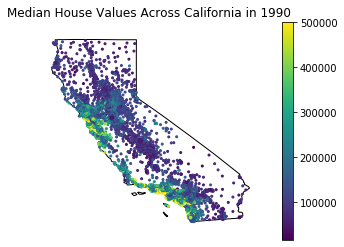

In [4]:
#select california from states map
states = geopandas.read_file('/home/david/Downloads/ca-county-boundaries/states.shp')
california = states[states['STATE_NAME'] == 'California']
#sets marker size to 2
def identity_scale(minval, maxval):
    def scalar(val):
        return 2
    return scalar

#plot CA in background and add points with hue based on median house value
ax  = california.plot(color='white',edgecolor='black')
geoplot.pointplot(gdf.geometry,scale = gdf.median_house_value,scale_func = identity_scale,ax=ax,hue = gdf.median_house_value,legend=True,legend_var='hue')
plt.title('Median House Values Across California in 1990')
plt.show()

To show how median income and median house values are correlated, in this map I scaled the points according to the median income. The previous graph is a bit swarmed with the number of close neighborhoods so it obscures some of the wealthier neighborhoods.

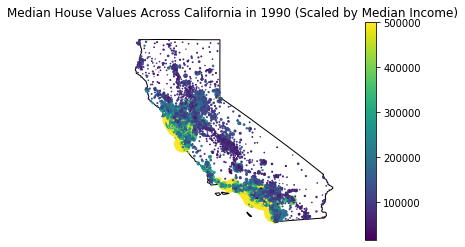

In [5]:
#power scale helps increase the marker size of wealthier communities.
def power_scale(minval, maxval):
    def scalar(val):
        val = val + abs(minval) + 1
        return (val/4)**2
    return scalar

ax  = california.plot(color='white',edgecolor='black')
geoplot.pointplot(gdf.geometry,scale = gdf.median_income,scale_func= power_scale,ax=ax,hue = gdf.median_house_value,legend=True,legend_var='hue')
plt.title('Median House Values Across California in 1990 (Scaled by Median Income)')
plt.show()

Here is a Kernel Density Estimate Plot of the neighborhoods in CA. With the previous two graphs, it was tough to get a real sense of the density, both show Northern and Southern CA to be about as dense in neighborhoods. But the KDE plot shows that Los Angeles has a lot more people and neighborhoods and the Bay Area is second most dense. The rural part of CA don't show up on this graph.

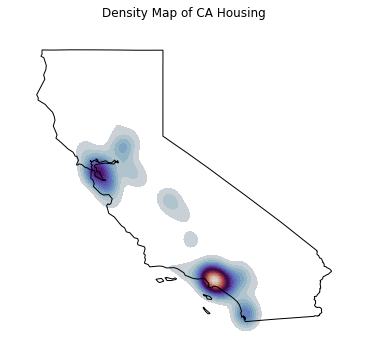

In [6]:
#density map of CA neighborhoods, silverman is the function for the KDE
ax2 = geoplot.kdeplot(gdf.geometry,shade=True,cmap='twilight',n_levels=30,bw='silverman')
geoplot.polyplot(california,ax=ax2,zorder=1)
plt.title('Density Map of CA Housing')
plt.show()

I graphed the ocean proximity of the points too, it gives some insight into the catagory. The <1H OCEAN was a surprisingly narrow strip of CA housing and knowing that allowed me to fine tune one of the regression feature to get better results.

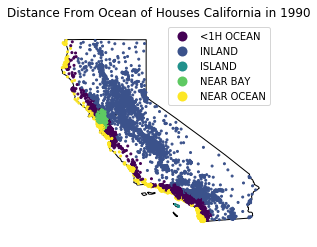

In [7]:
#Here the hue is the ocean proximity
ax  = california.plot(color='white',edgecolor='black')
geoplot.pointplot(gdf.geometry,scale = gdf.median_house_value,scale_func = identity_scale,ax=ax,hue = gdf.ocean_proximity,legend=True,legend_var='hue')
plt.title('Distance From Ocean of Houses California in 1990')
plt.show()

In [8]:
df.select('median_house_value').describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             20433|
|   mean|206864.41315519012|
| stddev|115435.66709858322|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



Here is where the variables that get put into the features columns for the model. Then I split the data 70/30 into a training and testing set.

In [9]:
#helps create features column
assembler =  VectorAssembler(inputCols=['housing_median_age','total_rooms','total_bedrooms','population','households','median_income','prox_index'], outputCol="features")
#random split random typed seed
train, test = df.randomSplit([0.70, 0.3], seed = 58313945)

This part of the code is responsible for giving a numeric value to the ocean_proximity variable. Using a string indexer made the model worse because it was randomly assigned, but if I correlated the values to what they actually meant close or far the model worked much better.

In [10]:
#prox_to_val converts value into a distance indicator
def prox_to_val(proximity):
    if ((proximity == 'NEAR BAY') | (proximity == 'ISLAND') | (proximity == 'NEAR OCEAN')):
        return 0
    if (proximity == '<1H OCEAN'):
        return 1
    if (proximity == 'INLAND'):
        return 4
    else:
        return 2
#apply this function to train and test
udf_func = F.udf(prox_to_val,types.IntegerType())
train = train.withColumn('prox_index',udf_func('ocean_proximity'))
test = test.withColumn('prox_index',udf_func('ocean_proximity'))

Here I run linear regression on the training data, then get a summary of the results. I also print out the coefficients and the intercept of the model. This shows that the model uses Median House Value and Ocean Proximity as the most weighted variables.

In [11]:

#linear regression fitting
linearRegression = GeneralizedLinearRegression().setMaxIter(20).setLabelCol('median_house_value')
pipeline_lr = Pipeline(stages=[assembler, linearRegression])
lrModel = pipeline_lr.fit(train.orderBy(F.rand()))
summary = lrModel.stages[1].summary
print("Coefficients: " + str(lrModel.stages[1].coefficients) + ", Intercept: " + str(lrModel.stages[1].intercept)) 

Coefficients: [1176.1125764516307,-8.970825426185803,83.74142770603738,-34.5764897929259,75.34029362650931,40825.789259675475,-20348.388718474984], Intercept: 40638.086948814096


Here I create an evaluator to grab the metrics of the linear regression model on the test data. The RSME tends to be < 70,000 dollars, and have a mean average error of 50,000 and I get an R^2 value of around ~.63. The fact that 63% of the variation in the data can be explained by changes in the variable is somewhat decent. The RSME value actually gets worse if I take out any of the other variables in the features. So I can take this linear regression model to be somewhat reliable prediction.

In [12]:
#evaluation of results, prints some predictions, RSME, R^2 and MAE
lr_pred = lrModel.transform(test)
print(lr_pred.select(['median_income','median_house_value','ocean_proximity','prediction']).orderBy(F.rand()).show(5))
lr_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_pred)
print("RMSE Test = %g" % rmse)
lr_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(lr_pred)
print("R^2 Test = %g" % r2)
lr_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(lr_pred)
print("Mean Absolute Error Test = %g" % mae)

+-------------+------------------+---------------+------------------+
|median_income|median_house_value|ocean_proximity|        prediction|
+-------------+------------------+---------------+------------------+
|       2.0577|           69000.0|         INLAND| 78631.72068440597|
|       4.6944|          248200.0|      <1H OCEAN|242729.12397290004|
|         2.25|           93400.0|      <1H OCEAN| 162105.5630500635|
|       3.3235|           87800.0|         INLAND|160622.78081922582|
|       3.4327|          147200.0|         INLAND|125846.93733181796|
+-------------+------------------+---------------+------------------+
only showing top 5 rows

None
RMSE Test = 69337.1
R^2 Test = 0.633789
Mean Absolute Error Test = 49994.7


Here I wanted to show the geographical distribution and house values of the close predictions (ones within the mean average error). Its good at predicting costs of coastal middle class communities as well as poorer inland communities. There arent any surprises here.

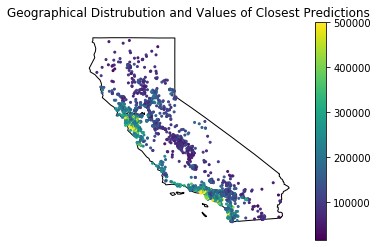

In [13]:
#creates new spark df with dif column, and then similar to above displays the geographic data of values less than the mean averagae error
lr_results = lr_pred.withColumn('dif',F.abs(lr_pred['prediction']-lr_pred['median_house_value']))
lr_top = lr_results.filter(lr_results['dif']<mae)
pdf_top = lr_top.select('longitude','latitude','median_income','median_house_value','ocean_proximity','dif').toPandas()
gdf_top = geopandas.GeoDataFrame(pdf_top[['median_income','median_house_value','ocean_proximity','dif']],geometry=geopandas.points_from_xy(pdf_top.longitude.astype(np.float32), pdf_top.latitude.astype(np.float32)))
ax  = california.plot(color='white',edgecolor='black')
geoplot.pointplot(gdf_top.geometry,scale = gdf_top.dif,scale_func = identity_scale,ax=ax,hue = gdf_top.median_house_value,legend=True,legend_var='hue')
plt.title('Geographical Distrubution and Values of Closest Predictions')
plt.show()

Then looking at the data for the worst predictions shows that the model struggles with the richest communities as well as some others scattered around. One spot I predicted it would fail at are some of the northern California coastal communities, which it did miss most of those neighborhoods.

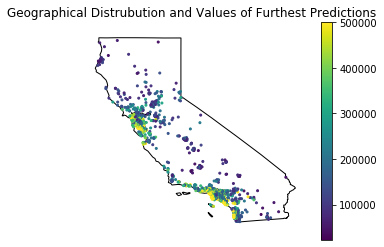

In [14]:
#creates new spark df with dif column, and then similar to above displays the geographic data of values greater than the mean averagae error
lr_bot = lr_results.filter(lr_results['dif']>=mae)
pdf_bot = lr_bot.select('longitude','latitude','median_income','median_house_value','ocean_proximity','dif').toPandas()
gdf_bot = geopandas.GeoDataFrame(pdf_bot[['median_income','median_house_value','ocean_proximity','dif']],geometry=geopandas.points_from_xy(pdf_bot.longitude.astype(np.float32), pdf_bot.latitude.astype(np.float32)))
ax  = california.plot(color='white',edgecolor='black')
geoplot.pointplot(gdf_bot.geometry,scale = gdf_bot.dif,scale_func=identity_scale,ax=ax,hue = gdf_bot.median_house_value,legend=True,legend_var='hue')
plt.title('Geographical Distrubution and Values of Furthest Predictions')
plt.show()

I also decided to make a Decision Tree Regression Model to have another model to compare to the other data. Pretty similar to the linear regression code with a different class. It actually performs quite similarly however is slightly worse in all metrics. Given that the Decision Tree will output one of 32 possible values, the scores are quite reliable.

In [15]:
#Decision tree regessor as a class,shows the same sets of results
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'median_house_value')
pipeline_dt = Pipeline(stages=[assembler, dt])
dt_model  = pipeline_dt.fit(train)
dt_pred = dt_model.transform(test)
print(dt_pred.select(['median_income','median_house_value','ocean_proximity','prediction']).orderBy(F.rand()).show(5))
dt_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_pred)
print("RMSE Test = %g" % rmse)
dt_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_pred)
print("R2 Test = %g" % r2)
dt_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
mae = dt_evaluator.evaluate(dt_pred)
print("Mean Absolute Error Test = %g" % mae)

+-------------+------------------+---------------+------------------+
|median_income|median_house_value|ocean_proximity|        prediction|
+-------------+------------------+---------------+------------------+
|        4.625|          228600.0|       NEAR BAY| 246421.4846743295|
|       7.0059|          500001.0|      <1H OCEAN| 429315.8287292818|
|       1.3676|           47800.0|         INLAND|   77607.197745013|
|       2.8958|          245800.0|      <1H OCEAN|179685.76002766253|
|          2.0|          175000.0|      <1H OCEAN|144518.12735042736|
+-------------+------------------+---------------+------------------+
only showing top 5 rows

None
RMSE Test = 70904.4
R2 Test = 0.617047
Mean Absolute Error Test = 51024.9


Debug String for Printing Out Tree

In [16]:
dt_model.stages[-1].toDebugString

'DecisionTreeRegressionModel: uid=DecisionTreeRegressor_222c1e78f0c4, depth=5, numNodes=63, numFeatures=7\n  If (feature 5 <= 5.0006)\n   If (feature 6 <= 2.5)\n    If (feature 5 <= 3.0392)\n     If (feature 5 <= 2.29335)\n      If (feature 4 <= 735.5)\n       Predict: 144518.12735042736\n      Else (feature 4 > 735.5)\n       Predict: 204376.51807228915\n     Else (feature 5 > 2.29335)\n      If (feature 0 <= 51.5)\n       Predict: 179685.76002766253\n      Else (feature 0 > 51.5)\n       Predict: 231980.62686567163\n    Else (feature 5 > 3.0392)\n     If (feature 0 <= 50.5)\n      If (feature 5 <= 4.05955)\n       Predict: 216054.76892605633\n      Else (feature 5 > 4.05955)\n       Predict: 246421.4846743295\n     Else (feature 0 > 50.5)\n      If (feature 2 <= 496.5)\n       Predict: 291996.6638297872\n      Else (feature 2 > 496.5)\n       Predict: 370903.7837837838\n   Else (feature 6 > 2.5)\n    If (feature 5 <= 3.0392)\n     If (feature 5 <= 2.29335)\n      If (feature 3 <= 365

Taking a look at the feature importances, 5. Median Income is the most important followed by 6. Ocean Proximity and then 0. Median Age of Buildings. Others make almost a negligible impact. Given that the feature importances follow the same trend as the linear regression, gives some confidence in both models and the importance of those variable compared to others.

In [17]:
#prints features
dt_model.stages[-1].featureImportances

SparseVector(7, {0: 0.0478, 2: 0.005, 3: 0.0011, 4: 0.0053, 5: 0.7141, 6: 0.2268})

Showing a portion of the decision tree to show how much median income plays a role. This was converted manually.

In [18]:
#displays html file
from IPython.display import HTML
HTML(filename="/home/david/Documents/decision_tree.html")